# Compare emission profiles -during production- for crops and livestock

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

## Load data

In [2]:
emissions_df = pd.read_parquet(r'../data/FAOSTAT/clean_data/all_tables_processed/food_emissions/merged_food_emissions_v2.parquet')

In [3]:
emissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252987 entries, 0 to 252986
Data columns (total 22 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Area Code                                          252987 non-null  int64  
 1   Area                                               252987 non-null  object 
 2   Year                                               252987 non-null  int64  
 3   Item Code                                          252987 non-null  int64  
 4   Item                                               252987 non-null  object 
 5   Stocks_(An)                                        252987 non-null  float64
 6   crops_or_livestock                                 252987 non-null  object 
 7   Burning_crop_residues_(Emissions_CH4_CO2eq)_(kt)   252987 non-null  float64
 8   Burning_crop_residues_(Emissions_N2O_CO2eq)_(kt)   252987 non-null  float6

# Visualize data

With this data better to focus on food items. Country totals are in "emissions_totals" table.

In [4]:
# There are countries and regions
# Function to select either coutries, continents, develop or world

def select_fao_region(df, region='country', path_to_areas=None, codes_col='Area Code'):
    """
    Selects data from a DataFrame based on specified FAO region.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing data to be filtered.
    region (str): The region to filter by. Options are 'country', 'continent', 'developed', or 'world'.
                  Default is 'country'.
    path_to_areas (str): Path to the CSV file containing area codes and their definitions. Required if region is 'country'.
    codes_col (str): The column name in df and the area codes file that contains the area codes. Default is 'Area Code'.

    Returns:
    pd.DataFrame: A DataFrame filtered by the specified region.

    Raises:
    ValueError: If region is 'country' and path_to_areas is not provided.
    """
    
    # Make a copy of the input DataFrame to avoid modifying the original data
    df = df.copy()
    
    # Define the area codes for different regions
    continent_codes = [5500, 5400, 5300, 5207, 5204, 5203, 5100]
    developed_codes = [5849, 5848]
    world_codes = [5000]
    
    if region == 'country':
        if not path_to_areas:
            raise ValueError("path_to_areas must be provided when selecting countries.")
        # Read the area codes from the CSV file, ensuring no duplicate entries
        area_codes = pd.read_csv(path_to_areas, encoding="ISO-8859-1").drop_duplicates()
        country_codes = area_codes[area_codes[codes_col] < 3000][codes_col].to_list()
        df = df[df[codes_col].isin(country_codes)]
    elif region == 'continent':
        df = df[df[codes_col].isin(continent_codes)]
    elif region == 'developed':
        df = df[df[codes_col].isin(developed_codes)]
    elif region == 'world':
        df = df[df[codes_col].isin(world_codes)]
    
    return df

## Crops vs Livestock, per year.

- In world
- Developed vs. Developing
- Continents

In [5]:
# Exclude fao projections
emissions_df = emissions_df[emissions_df['Year'] <= 2022]

In [6]:
world = select_fao_region(emissions_df, region='world')
dev_and_notdev = select_fao_region(emissions_df, region='developed')
continents = select_fao_region(emissions_df, region='continent')

Define color pallets:

In [7]:
continent_palette = {
    'Africa': '#4E79A7',           # Blue
    'Asia': '#EDC948',             # Yellow
    'Europe': '#E15759',           # Red
    'Northern America': '#76B7B2',    # Light Blue
    'Oceania': '#B07AA1',          # Purple
    'South America': '#59A14F',    # Green
    'Central America': '#F28E2B'   # Orange
}

crops_livestock_palette = {
    'crops': '#1f77b4',    # Blue
    'livestock': '#ff7f0e' # Orange
}

dev_palette = {
    'Non-Annex I countries': '#d62728', # Red
    'Annex I countries': '#2ca02c'   # Green
}

/tmp/ipykernel_55691/3705603843.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_55691/3705603843.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_55691/3705603843.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_55691/3705603843.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')


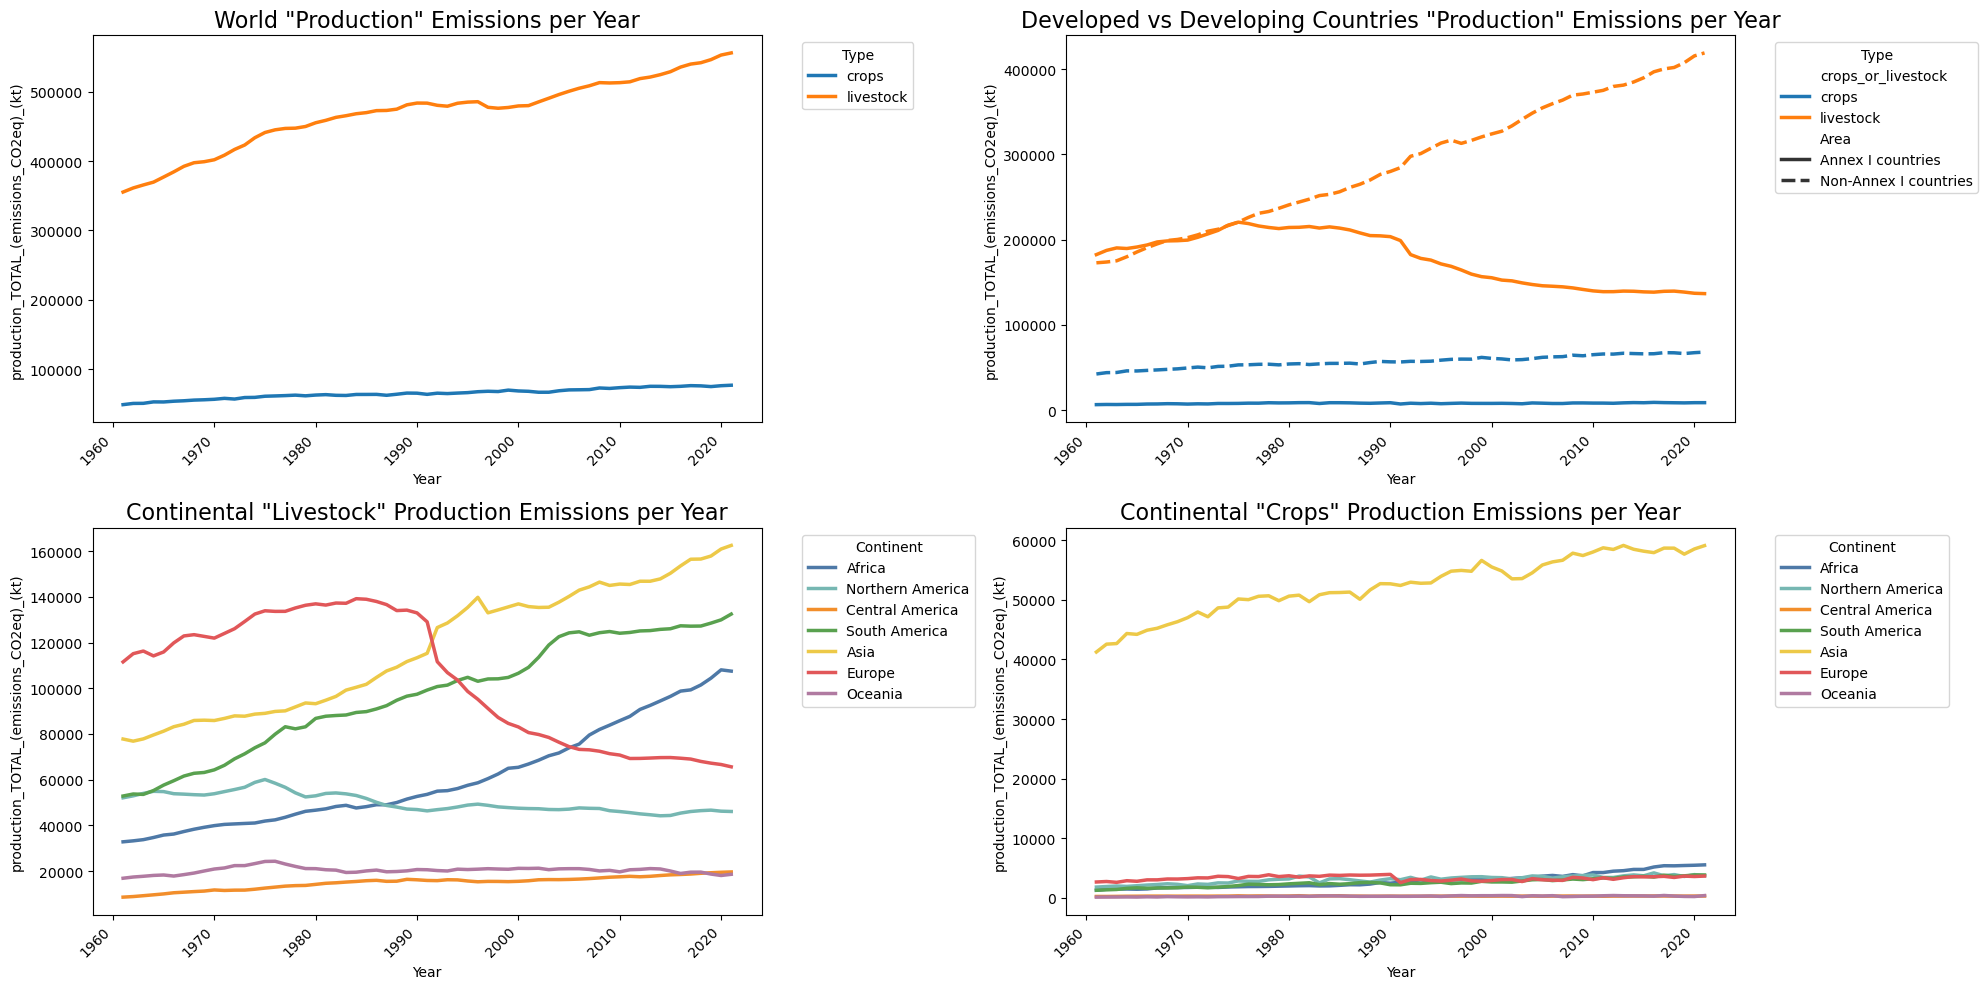

In [8]:
# Further filter data for livestock and crops
livestock_data_continents = continents[continents["crops_or_livestock"] == "livestock"]
crops_data_continents = continents[continents["crops_or_livestock"] == "crops"]

# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

# Plot for the world overall
sns.lineplot(
    data=world, 
    x="Year", 
    y="production_TOTAL_(emissions_CO2eq)_(kt)", 
    hue="crops_or_livestock", 
    errorbar=None,
    linewidth=2.5,  # Make the lines thicker
    palette=crops_livestock_palette,
    ax=ax1
)
ax1.set_title('World "Production" Emissions per Year', fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for developed vs. developing countries
sns.lineplot(
    data=dev_and_notdev, 
    x="Year", 
    y="production_TOTAL_(emissions_CO2eq)_(kt)", 
    hue="crops_or_livestock", 
    style="Area",
    errorbar=None,
    linewidth=2.5,  # Make the lines thicker
    ax=ax2
)
ax2.set_title('Developed vs Developing Countries "Production" Emissions per Year', fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for continents with livestock
sns.lineplot(
    data=livestock_data_continents, 
    x="Year", 
    y="production_TOTAL_(emissions_CO2eq)_(kt)", 
    hue="Area",
    errorbar=None,
    linewidth=2.5,  # Make the lines thicker
    palette=continent_palette,
    ax=ax3
)
ax3.set_title('Continental "Livestock" Production Emissions per Year', fontsize=16)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for continents with crops
sns.lineplot(
    data=crops_data_continents, 
    x="Year", 
    y="production_TOTAL_(emissions_CO2eq)_(kt)", 
    hue="Area",
    errorbar=None,
    linewidth=2.5,  # Make the lines thicker
    palette=continent_palette,
    ax=ax4
)
ax4.set_title('Continental "Crops" Production Emissions per Year', fontsize=16)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('../plots/crops_vs_livestock_production_emissions_lineplot_2x2.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
from scipy.stats import linregress

# Filtrar datos de "livestock" y "crops" para todo el mundo
livestock_world = world[world["crops_or_livestock"] == "livestock"]
crops_world = world[world["crops_or_livestock"] == "crops"]

# Calcular la pendiente para "livestock"
slope_livestock, intercept, r_value, p_value, std_err = linregress(livestock_world["Year"], livestock_world["production_TOTAL_(emissions_CO2eq)_(kt)"])

# Calcular la pendiente para "crops"
slope_crops, intercept, r_value, p_value, std_err = linregress(crops_world["Year"], crops_world["production_TOTAL_(emissions_CO2eq)_(kt)"])

# Imprimir pendientes
print(f"Pendiente Livestock: {slope_livestock}")
print(f"Pendiente Crops: {slope_crops}")

Pendiente Livestock: 2771.7632499497613
Pendiente Crops: 408.02285191609354


## For Year 2021

/tmp/ipykernel_55691/2445173363.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
/tmp/ipykernel_55691/2445173363.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')


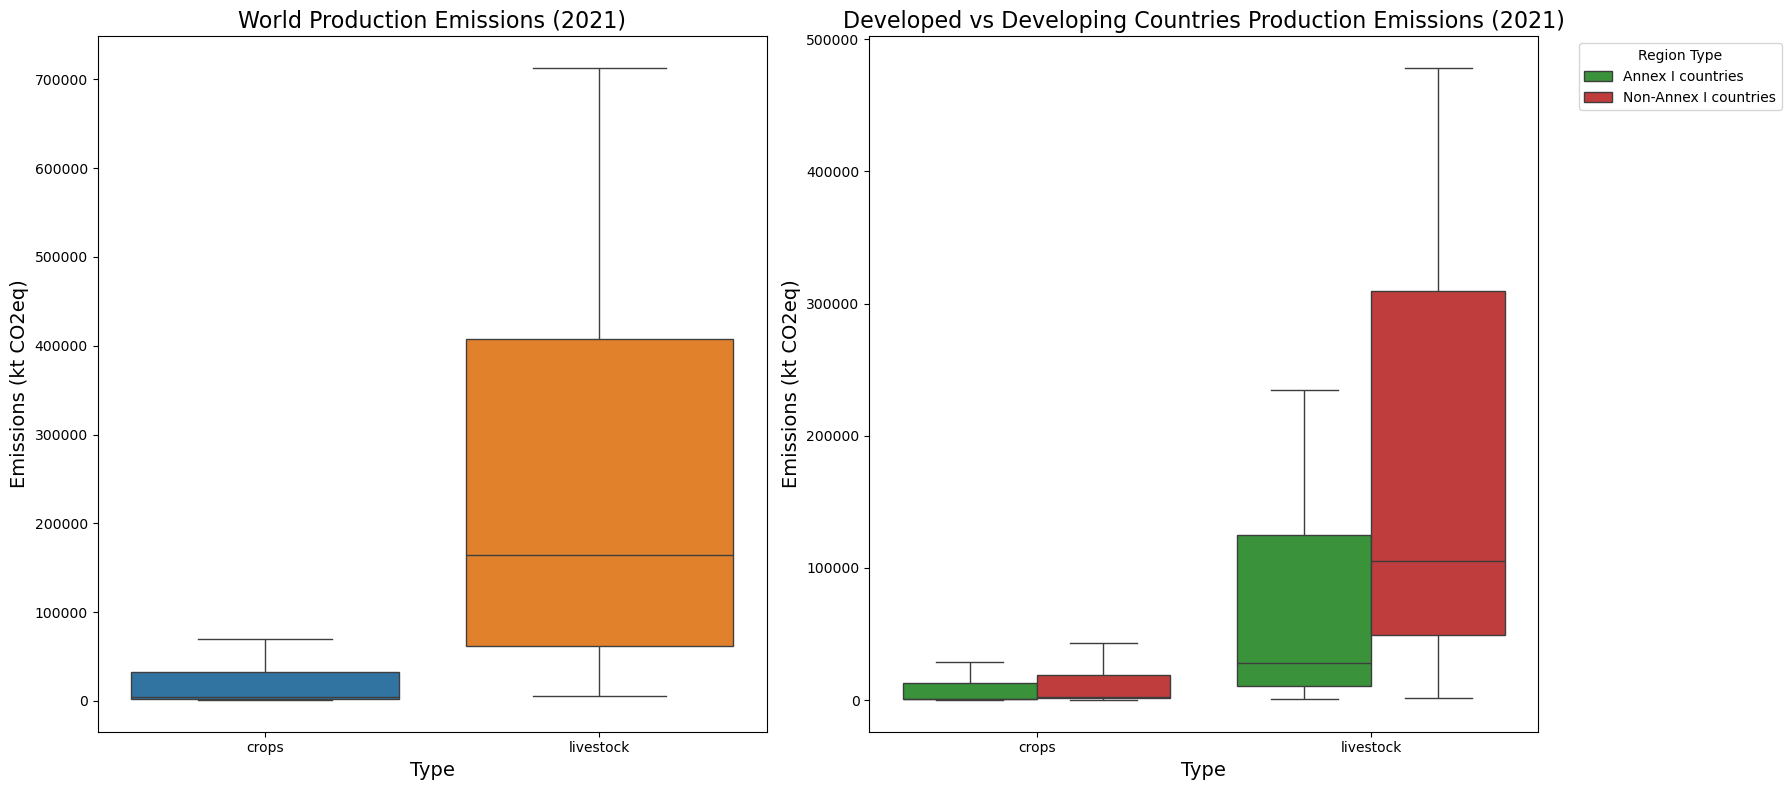

In [10]:
# Filter data for the year 2021
world_2021 = world[world['Year'] == 2021]
dev_and_notdev_2021 = dev_and_notdev[dev_and_notdev['Year'] == 2021]

# Create a figure with 1 row and 2 columns of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Boxplot for the world
sns.boxplot(
    data=world_2021, 
    x='crops_or_livestock', 
    y='production_TOTAL_(emissions_CO2eq)_(kt)', 
    hue='crops_or_livestock',  # Use hue to differentiate crops and livestock
    palette=crops_livestock_palette,          # Apply the color palette
    showfliers=False,         # Do not show outliers
    ax=ax1
)
ax1.set_title('World Production Emissions (2021)', fontsize=16)
ax1.set_xlabel('Type', fontsize=14)
ax1.set_ylabel('Emissions (kt CO2eq)', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')

# Boxplot for developed vs developing countries
sns.boxplot(
    data=dev_and_notdev_2021, 
    x='crops_or_livestock', 
    y='production_TOTAL_(emissions_CO2eq)_(kt)', 
    hue='Area',  # Use hue to differentiate developed vs developing
    palette=dev_palette,  # Apply the color palette
    showfliers=False,  # Do not show outliers
    ax=ax2
)
ax2.set_title('Developed vs Developing Countries Production Emissions (2021)', fontsize=16)
ax2.set_xlabel('Type', fontsize=14)
ax2.set_ylabel('Emissions (kt CO2eq)', fontsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')
ax2.legend(title='Region Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('../plots/crops_vs_livestock_boxplots_2021_row.png', dpi=300, bbox_inches='tight')
plt.show()


## All crops and livestocks TOTAL emissions

Total overall vs total 2021

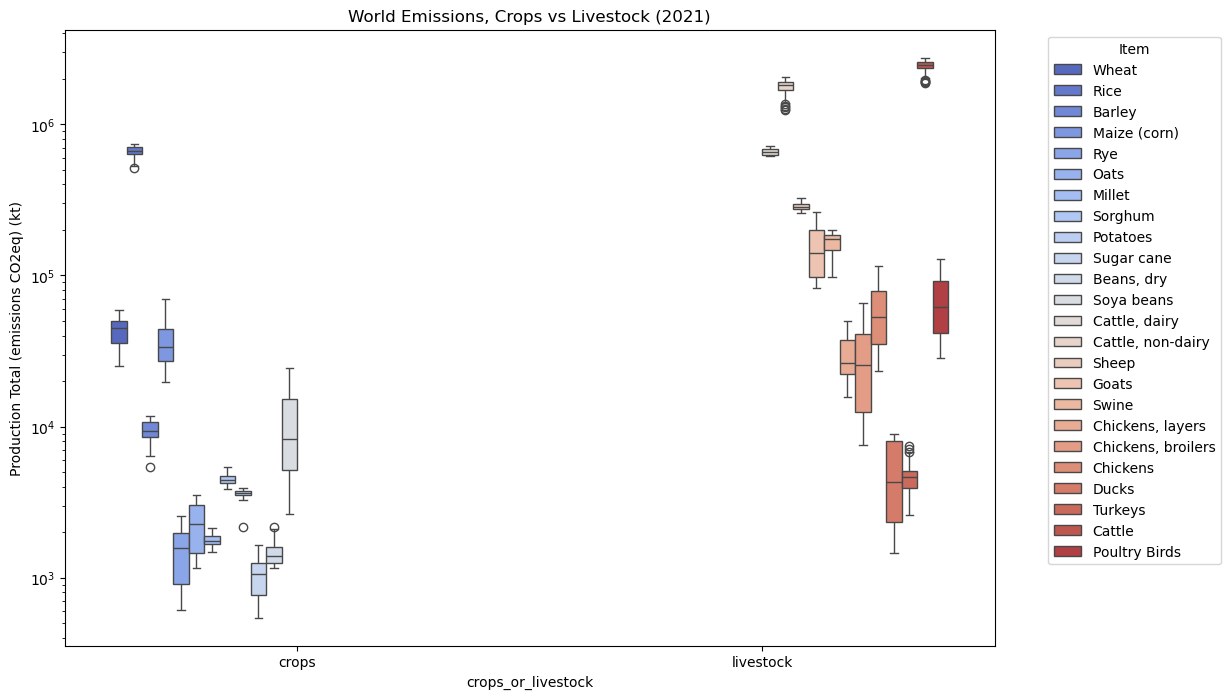

In [11]:
# Create the plot
plt.figure(figsize=(12, 8))

# Get unique items and create a color palette
items = world['Item'].unique()
palette = sns.color_palette("coolwarm", n_colors=len(items))

# Boxplot with modified width and spacing
sns.boxplot(
    data=world, 
    x='crops_or_livestock', 
    y='production_TOTAL_(emissions_CO2eq)_(kt)', 
    hue='Item',
    # legend=False,
    palette=palette  # Use the coolwarm palett
)

# Adjust the legend position to the right of the plot
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add title and labels
plt.title('World Emissions, Crops vs Livestock (2021)')
plt.ylabel('Production Total (emissions CO2eq) (kt)')

# Set y-axis to log scale
plt.yscale('log')

# Adjust layout and save the plot
plt.savefig('../plots/all_food_items_prodemissions_boxplots2.pdf', bbox_inches = 'tight')
plt.show()

# Tree Map of top emission items for crops and livestock (Rice and Cattle)

I will compare them inside each tree map to another item (wheat and chickens)

In [137]:
crops_columns = ['Burning_crop_residues_(Emissions_CH4_CO2eq)_(kt)',
       'Burning_crop_residues_(Emissions_N2O_CO2eq)_(kt)',
       'Crop_residues_(Emissions_N2O_CO2eq)_(kt)',
       'Rice_cultivation_(Emissions_CH4_CO2eq)_(kt)',
       'Synthetic_fertilizers_(Emissions_N2O_CO2eq)_(kt)',
       'Item']

livestock_columns = ['Emissions_(N2O_CO2eq)_(Manure_applied)_(kt)',
       'Enteric_fermentation_(Emissions_CH4_CO2eq)_(kt)',
       'Manure_left_on_pasture_(Emissions_N2O_CO2eq)_(kt)',
       'Manure_management_(Emissions_CH4_CO2eq)_(kt)',
       'Manure_management_(Emissions_N2O_CO2eq)_(kt)',
       'Item']

selected_crops = ['Rice', 'Wheat']
selected_livestock = ['Cattle', 'Chickens']

world_2021_selected_crops = world_2021[world_2021['Item'].isin(selected_crops)]
world_2021_selected_livestock = world_2021[world_2021['Item'].isin(selected_livestock)]

# Filter columns for crops and livestock
world_2021_selected_crops = world_2021_selected_crops[crops_columns]
world_2021_selected_livestock = world_2021_selected_livestock[livestock_columns]

In [138]:
# Rename the columns for crops
world_2021_selected_crops.columns = ['Burn_CH4', 'Burn_N2O', 'Crop_Res_N2O', 'Rice_Cult_CH4', 'Fert_N2O', 'Item']

# Rename the columns for livestock
world_2021_selected_livestock.columns = ['Manure_N2O', 'Enteric_CH4', 'Pasture_N2O', 'ManureMgmt_CH4', 'ManureMgmt_N2O', 'Item']

In [139]:
treemap_crops = pd.melt(world_2021_selected_crops, id_vars=['Item'], var_name="emission_type", value_name="emission_value")
treemap_livestock = pd.melt(world_2021_selected_livestock, id_vars=['Item'], var_name="emission_type", value_name="emission_value")

Transform to percentage values

In [140]:
crops_total = treemap_crops['emission_value'].sum()
treemap_crops['emission_value'] = (treemap_crops['emission_value'] / crops_total) * 100

livestock_total = treemap_livestock['emission_value'].sum()
treemap_livestock['emission_value'] = (treemap_livestock['emission_value'] / livestock_total) * 100

In [141]:
treemap_livestock['emission_type'] = treemap_livestock['emission_type'] + '_' + treemap_livestock['Item']
treemap_livestock = treemap_livestock[treemap_livestock['emission_value'] > 0]

In [142]:
treemap_crops['emission_type'] = treemap_crops['emission_type'] + '_' + treemap_crops['Item']
treemap_crops = treemap_crops[treemap_crops['emission_value'] > 0]

## Create both treemaps

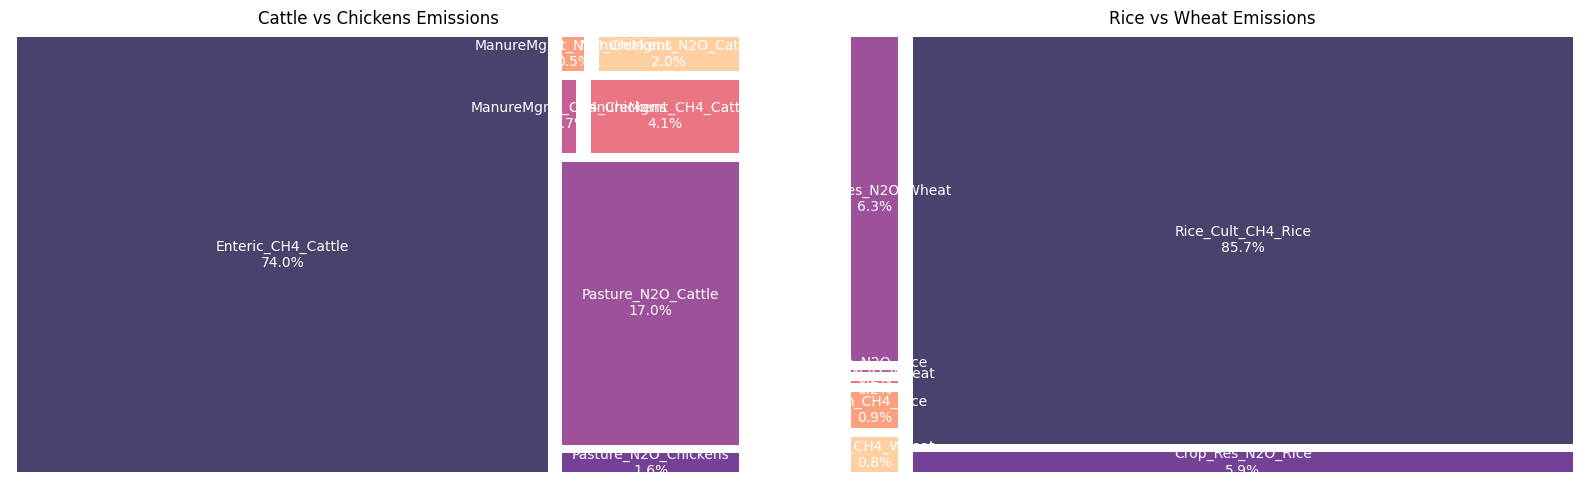

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

labels_liv = [f"{label}\n{value:.1f}%" for label, value in zip(treemap_livestock['emission_type'], treemap_livestock['emission_value'])]
labels_c = [f"{label}\n{value:.1f}%" for label, value in zip(treemap_crops['emission_type'], treemap_crops['emission_value'])]

# Reverse the color palette
magma_colors = sns.color_palette("magma", len(treemap_livestock['emission_value'])).as_hex()
magma_colors_reversed = magma_colors[::-1]

# Plot for livestock emissions
squarify.plot(
    sizes=treemap_livestock['emission_value'], 
    label=labels_liv,
    alpha=.8,
    pad=0.25,
    text_kwargs={'fontsize': 10, 'color': 'white'},
    color=magma_colors,
    ax=ax1
)
ax1.set_title('Cattle vs Chickens Emissions')
ax1.axis('off')

# Plot for crop emissions
squarify.plot(
    sizes=treemap_crops['emission_value'],
    label=labels_c,
    alpha=.8,
    pad=0.25,
    text_kwargs={'fontsize': 10, 'color': 'white'},
    color=magma_colors_reversed,
    ax=ax2
)
ax2.set_title('Rice vs Wheat Emissions')
ax2.axis('off')

# Show plot
plt.tight_layout()
# plt.savefig('../plots/all_food_items_prodemissions_boxplots.png', dpi=300, bbox_inches='tight')

plt.savefig('../plots/treemaps_emissions.pdf', format='pdf')
plt.savefig('../plots/treemaps_emissions.png', format='png')
plt.show()